In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import matplotlib.pyplot as plt

import numpy as np
import gzip
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Mount files
from google.colab import drive
drive.mount('/content/drive')
# Loading images and labels from .gz files
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        # First 16 bytes are metadata about the file
        f.read(16)
        # The remaining bytes are the image pixels
        buf = f.read()
        images = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        # Reshape into [number of images, height, width]
        images = images.reshape(-1, 28, 28) / 255.0  # normalize to [0, 1] range
    return torch.tensor(images).unsqueeze(1)  # add channel dimension (1, 28, 28)

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        # First 8 bytes are metadata about the file
        f.read(8)
        # The remaining bytes are the label data
        buf = f.read()
        labels = np.frombuffer(buf, dtype=np.uint8)
    return torch.tensor(labels)

# Load training data
train_images = load_mnist_images('/content/drive/MyDrive/Colab Notebooks/data/train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('/content/drive/MyDrive/Colab Notebooks/data/train-labels-idx1-ubyte.gz')

# Load test data
test_images = load_mnist_images('/content/drive/MyDrive/Colab Notebooks/data/test-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('/content/drive/MyDrive/Colab Notebooks/data/test-labels-idx1-ubyte.gz')

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Split training dataset into training set and validation set (80, 20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Defining our models

In [ ]:
"""
1. Batchnorm after RELU
2. One dropout after fc2
"""

class LeNet5_BN_After_Relu_One_DropOut(nn.Module):
    def __init__(self, dropout=False, batch_norm=False, dropout_p = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p=dropout_p) if dropout else nn.Identity()
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x) # no-op if batch_norm is False
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x) # no-op if batch_norm is False
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4) # can be replaced with torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x) # no-op if dropout is False
        x = self.fc3(x)
        return x

In [ ]:
"""
1. Batchnorm before RELU, instead of after
2. Two dropouts: once after fc1 + once after fc2
"""

class LeNet5_BN_Before_Relu_Two_DropOut(nn.Module):
    def __init__(self, dropout=False, batch_norm=False, dropout_p = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p=dropout_p) if dropout else nn.Identity()
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()

    def forward(self, x):
        # First layer + batchnorm + pooling
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Second layer + batchnorm + pooling
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Flatten for FC layers
        x = x.view(-1, 16*4*4)

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
"""
1. Batchnorm before RELU, instead of after
2. One dropout: once after fc2
"""

class LeNet5_BN_Before_Relu_One_DropOut(nn.Module):
    def __init__(self, dropout=False, batch_norm=False, dropout_p = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p=dropout_p) if dropout else nn.Identity()
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()

    def forward(self, x):
        # First layer + batchnorm + pooling
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Second layer + batchnorm + pooling
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Flatten for FC layers
        x = x.view(-1, 16*4*4)

        # FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, loss_fn, optimizer, epochs=10, measure_without_dropout=False):
    best_val_accuracy = 0.0
    best_model_state = None
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()
            # Adjust learning weights
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total

        # for model using dropout regularization, go over the training set and measure the accuracy wo dropout
        if measure_without_dropout:
            train_accuracy = evaluate_model(model, train_loader)
            model.train()  # set back to train=true

        train_accuracies.append(train_accuracy)

        # Validation phase
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        # test the model for each epoch
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%, Test Accuracy: {test_accuracy}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # best_model_state = model.state_dict() # shallow copy
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}  # deep copy

    # Load the best model state
    model.load_state_dict(best_model_state)
    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    # Disable gradient computation and reduce memory consumption
    with torch.no_grad():
        for images, labels in data_loader:
            # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Training

In [ ]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define the models and their configurations
models_config = {
    "model_no_reg": [
        {"model": {"name": "no regularization", "module": LeNet5_BN_Before_Relu_One_DropOut().to(device)}}
    ],
    "model_with_dropout": [
        {"model": {"name": "two dropouts with 0.3 probability", "module": LeNet5_BN_Before_Relu_Two_DropOut(dropout=True, dropout_p=0.3).to(device)}},
        {"model": {"name": "two dropouts with 0.5 probability", "module": LeNet5_BN_Before_Relu_Two_DropOut(dropout=True, dropout_p=0.5).to(device)}},
        {"model": {"name": "two dropouts with 0.7 probability", "module": LeNet5_BN_Before_Relu_Two_DropOut(dropout=True, dropout_p=0.7).to(device)}},
        {"model": {"name": "one dropout with 0.3 probability", "module": LeNet5_BN_After_Relu_One_DropOut(dropout=True, dropout_p=0.3).to(device)}},
        {"model": {"name": "one dropout with 0.5 probability", "module": LeNet5_BN_After_Relu_One_DropOut(dropout=True, dropout_p=0.5).to(device)}}
    ],
    "model_with_batchnorm": [
        {"model": {"name": "batchnorm before RELU", "module": LeNet5_BN_Before_Relu_One_DropOut(batch_norm=True).to(device)}},
        {"model": {"name": "batchnorm after RELU", "module": LeNet5_BN_After_Relu_One_DropOut(batch_norm=True).to(device)}}
    ],
    "model_with_weight_decay": [
        {"model": {"name": "weight decay 1e-2", "module": LeNet5_BN_Before_Relu_One_DropOut().to(device)}, "params": {"weight_decay": 1e-2}},
        {"model": {"name": "weight decay 1e-3", "module": LeNet5_BN_Before_Relu_One_DropOut().to(device)}, "params": {"weight_decay": 1e-3}},
        {"model": {"name": "weight decay 1e-4", "module": LeNet5_BN_Before_Relu_One_DropOut().to(device)}, "params": {"weight_decay": 1e-4}}
    ]
}
# Initialize the result dictionary
result = {}

# Iterate over learning rates and models
for model_name, model_info in models_config.items():
    for model_dict in model_info:
        initial_state = {}
        for learning_rate in [1e-2, 1e-3, 1e-4]:
            name = model_dict.get("model", {}).get("name", model_name+"default")
            model = model_dict.get("model", {}).get("module", LeNet5_BN_Before_Relu_One_DropOut().to(device))
            params = model_dict.get("params", {})

            # Save the initial state of the model
            if learning_rate == 1e-2:
               initial_state = {k: v.clone() for k, v in model.state_dict().items()}  # deep copy

            # Reset the model's parameters at the beginning of each learning rate iteration
            else:
              model.load_state_dict(initial_state)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate, **params)

            # Train the model
            if(model_name == 'model_with_dropout'):
              model_optimized, train_accuracies, val_accuracies, test_accuracies = train_model(model, loss_fn, optimizer, 15, measure_without_dropout=True)
            else:
              model_optimized, train_accuracies, val_accuracies, test_accuracies = train_model(model, loss_fn, optimizer, 15)

            # Evaluate the model on the test set
            test_accuracy = evaluate_model(model_optimized, test_loader)

            # Update the result dictionary with the maximum test accuracy
            if model_name not in result or test_accuracy > result[model_name]['test_accuracy']:
                model_optimized_state = {k: v.clone() for k, v in model_optimized.state_dict().items()}  # deep copy
                result[model_name] = {
                    'name': name,
                    'model': model_optimized,
                    'parameters': model_optimized_state,
                    'learning_rate': learning_rate,
                    'test_accuracy': test_accuracy,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'test_accuracies': test_accuracies
                }
            print(f"Model: {model_name}, desc: {name}, Learning rate: {learning_rate}, Test Accuracy: {test_accuracy}%")

# Print the final results
print("Final Results:")
for model_name, info in result.items():
    print(f"Model: {model_name}, Best Learning Rate: {info['learning_rate']}, Best Test Accuracy: {info['test_accuracy']}%")

Epoch 1/15, Train Accuracy: 77.73333333333333%, Validation Accuracy: 84.09166666666667%, Test Accuracy: 83.82%
Epoch 2/15, Train Accuracy: 85.10208333333334%, Validation Accuracy: 85.4%, Test Accuracy: 84.87%
Epoch 3/15, Train Accuracy: 86.525%, Validation Accuracy: 86.55%, Test Accuracy: 86.19%
Epoch 4/15, Train Accuracy: 86.975%, Validation Accuracy: 86.21666666666667%, Test Accuracy: 85.29%
Epoch 5/15, Train Accuracy: 87.34166666666667%, Validation Accuracy: 87.10833333333333%, Test Accuracy: 86.15%
Epoch 6/15, Train Accuracy: 87.75833333333334%, Validation Accuracy: 87.04166666666667%, Test Accuracy: 86.41%
Epoch 7/15, Train Accuracy: 87.9%, Validation Accuracy: 87.075%, Test Accuracy: 86.54%
Epoch 8/15, Train Accuracy: 88.3125%, Validation Accuracy: 87.65833333333333%, Test Accuracy: 87.62%
Epoch 9/15, Train Accuracy: 88.45625%, Validation Accuracy: 87.925%, Test Accuracy: 87.56%
Epoch 10/15, Train Accuracy: 88.7%, Validation Accuracy: 87.15%, Test Accuracy: 86.0%
Epoch 11/15, Tra

# Plotting + Table

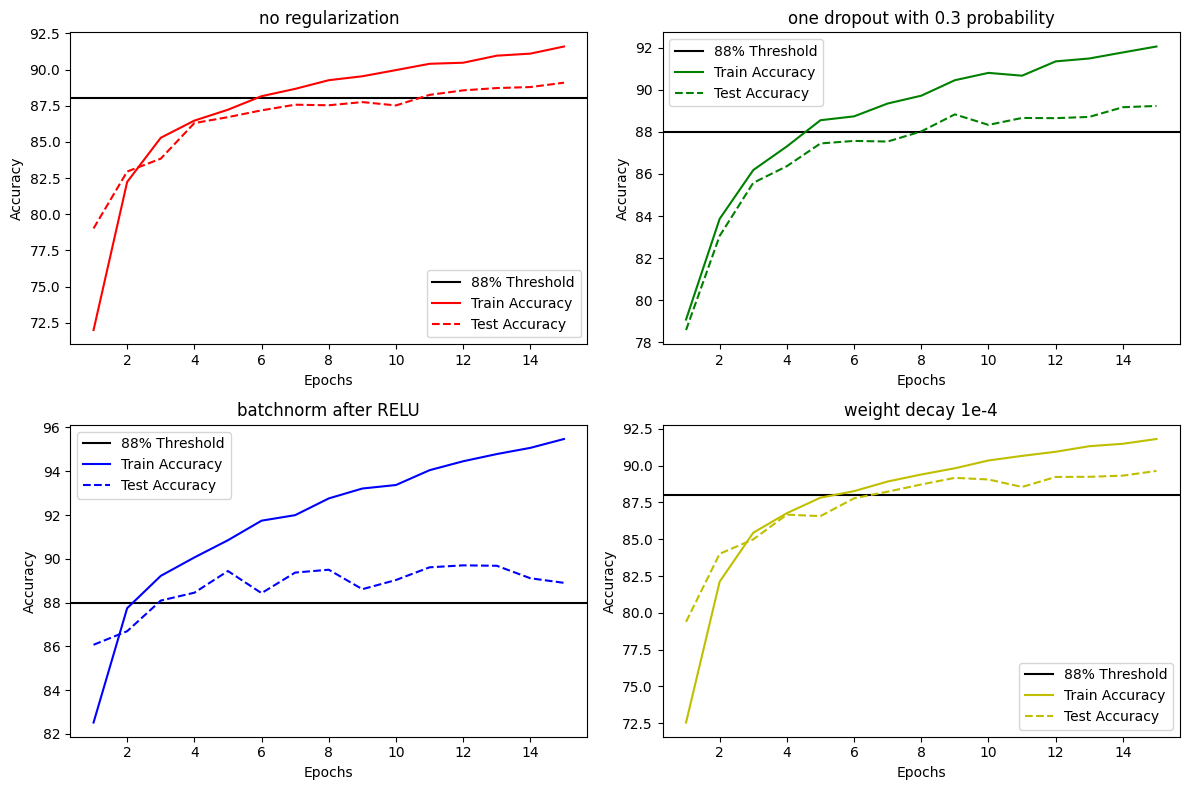

In [ ]:
epochs = range(1, 16)

def plot_accuracy(epochs, train_accuracies, test_accuracies, title, color):
    plt.plot(epochs, train_accuracies, color=color, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, color=color, linestyle='--', label='Test Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Plotting convergence graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.axhline(y=88, color='black', linestyle='-', label='88% Threshold')
model = result['model_no_reg']
plot_accuracy(epochs, model['train_accuracies'], model['test_accuracies'], model['name'], color='r')

plt.subplot(2, 2, 2)
plt.axhline(y=88, color='black', linestyle='-', label='88% Threshold')
model = result['model_with_dropout']
plot_accuracy(epochs, model['train_accuracies'], model['test_accuracies'], model['name'], color='g')

plt.subplot(2, 2, 3)
plt.axhline(y=88, color='black', linestyle='-', label='88% Threshold')
model = result['model_with_batchnorm']
plot_accuracy(epochs, model['train_accuracies'], model['test_accuracies'], model['name'], color='b')

plt.subplot(2, 2, 4)
plt.axhline(y=88, color='black', linestyle='-', label='88% Threshold')
model = result['model_with_weight_decay']
plot_accuracy(epochs, model['train_accuracies'], model['test_accuracies'], model['name'], color='y')

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

data = {
    "Model/Technique": ["Baseline (No Regularization)", "Dropout", "Batch Normalization", "Weight Decay (L2)"],
    "Final Train Accuracy (%)": [result["model_no_reg"]['train_accuracies'][len(epochs)-1],
                                 result["model_with_dropout"]['train_accuracies'][len(epochs)-1],
                                 result["model_with_batchnorm"]['train_accuracies'][len(epochs)-1],
                                 result["model_with_weight_decay"]['train_accuracies'][len(epochs)-1]],
    "Final Test Accuracy (%)": [result["model_no_reg"]["test_accuracy"],
                                result["model_with_dropout"]["test_accuracy"],
                                result["model_with_batchnorm"]["test_accuracy"],
                                result["model_with_weight_decay"]["test_accuracy"]]
}

# Display table
df = pd.DataFrame(data)
df["Final Train Accuracy (%)"] = df["Final Train Accuracy (%)"].map("{:.2f}".format)

fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='coral',
                align='left'),
    cells=dict(values=[df[col] for col in df.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(
    title="Final Accuracies for Various Techniques",
    height=400,
    width=600
)

fig.show()

# Testing

In [ ]:
model_to_test = result["model_no_reg"]["model"]
model_params = result["model_no_reg"]["parameters"]
model_to_test.load_state_dict(model_params)

# Evaluate our best model for no regularization
# Checked if it yields the same highest test_accuracy
test_accuracy = evaluate_model(model_to_test, test_loader)
print(test_accuracy)
print(test_accuracy == result["model_no_reg"]["test_accuracy"])

89.09
True


In [ ]:
model_to_test = result["model_with_dropout"]["model"]
model_params = result["model_with_dropout"]["parameters"]
model_to_test.load_state_dict(model_params)

# Evaluate our best model using dropout
# Checked if it yields the same highest test_accuracy
test_accuracy = evaluate_model(model_to_test, test_loader)
print(test_accuracy)
print(test_accuracy == result["model_with_dropout"]["test_accuracy"])

89.23
True


In [ ]:
model_to_test = result["model_with_batchnorm"]["model"]
model_params = result["model_with_batchnorm"]["parameters"]
model_to_test.load_state_dict(model_params)

# Evaluate our best model using batch normalization
# Checked if it yields the same highest test_accuracy
test_accuracy = evaluate_model(model_to_test, test_loader)
print(test_accuracy)
print(test_accuracy == result["model_with_batchnorm"]["test_accuracy"])

89.61
True


In [ ]:
model_to_test = result["model_with_weight_decay"]["model"]
model_params = result["model_with_weight_decay"]["parameters"]
model_to_test.load_state_dict(model_params)

# Evaluate our best model using weight decay
# Checked if it yields the same highest test_accuracy
test_accuracy = evaluate_model(model_to_test, test_loader)
print(test_accuracy)
print(test_accuracy == result["model_with_weight_decay"]["test_accuracy"])

89.64
True
